# Optimizing NLP Mental Health Classifier

- **Title**: Optimizing NLP Mental Health Classifier
- **Team Members**: Sameer Rajendra Siddhant Khairnar

In [1]:
import pandas as pd
data = pd.read_csv('mental_health.csv')
# print(data.head())


In [2]:
import re
import torch
import torch.nn as nn
from transformers import RobertaTokenizer, RobertaForSequenceClassification, AdamW, get_scheduler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import pandas as pd
import matplotlib.pyplot as plt

def clean_text(text):
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)
    text = re.sub(r'\@\w+|\#', '', text)
    text = text.lower()
    return text

data['cleaned_text'] = data['text'].apply(clean_text)
print(data['cleaned_text'])

0        dear american teens question dutch person hear...
1        nothing look forward lifei dont many reasons k...
2        music recommendations im looking expand playli...
3        im done trying feel betterthe reason im still ...
4        worried  year old girl subject domestic physic...
                               ...                        
27972    posting everyday people stop caring  religion ...
27973    okay definetly need hear guys opinion ive pret...
27974    cant get dog think ill kill myselfthe last thi...
27975    whats point princess bridei really think like ...
27976    got nudes person might might know snapchat do ...
Name: cleaned_text, Length: 27977, dtype: object


In [3]:
# Load RoBERTa tokenizer and model
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=2)


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [4]:
from transformers import RobertaTokenizer
from torch.utils.data import DataLoader, Dataset

data['gender'] = data['gender'].map({'male': 1, 'Female': 0})


# Initialize the tokenizer
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

# Tokenize the text column
data['tokens'] = data['text'].apply(lambda x: tokenizer.encode(x, truncation=True, padding='max_length', max_length=128))

# Split the data into training and testing sets
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

# Define the Dataset class
class TextDataset(Dataset):
    def __init__(self, df, tokenizer):
        self.labels = df['label'].values
        self.genders = df['gender'].values  # Including gender for fairness
        self.inputs = tokenizer(df['text'].tolist(), padding=True, truncation=True, return_tensors="pt", max_length=512)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'input_ids': self.inputs['input_ids'][idx],
            'attention_mask': self.inputs['attention_mask'][idx],
            'label': torch.tensor(self.labels[idx], dtype=torch.long),
            'gender': torch.tensor(self.genders[idx], dtype=torch.long)  # Assuming gender is provided
        }


train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)
train_dataset = TextDataset(train_data, tokenizer)
test_dataset = TextDataset(test_data, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=26, shuffle=True,num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=26, shuffle=False,num_workers=0)

In [5]:
def demographic_parity_loss(predictions, labels, genders):
    male_indices = (genders == 1)
    female_indices = (genders == 0)
    
    male_pos_rate = predictions[male_indices].mean()
    female_pos_rate = predictions[female_indices].mean()
    
    return torch.abs(male_pos_rate - female_pos_rate)


In [ ]:
# Set the number of threads for PyTorch CPU operations
torch.set_num_threads(4)  # Adjust based on your system
print(f"Using {torch.get_num_threads()} threads for CPU operations.")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print("device: ", device)
from torch.amp import autocast,GradScaler
# optimizer and scheduler
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)
criterion = torch.nn.CrossEntropyLoss()  # For binary classification
# Mixed Precision Training Setup
scaler = GradScaler()
max_norm = 1.0  # Gradient clipping threshold

train_losses,train_accuracies=[],[]
learning_rates = []  # To track learning rates
bias_metrics = []  # List to store bias metrics for each epoch
fairness_metrics = []
# Training loop
num_epochs = 7
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    correct_predictions = 0
    total_samples = 0
    gender_pred_counts = {'male': {'positive': 0, 'total': 0}, 'female': {'positive': 0, 'total': 0}}

    for batch in train_loader:
        optimizer.zero_grad()

        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)
        genders = batch['gender'].to(device)

        # Mixed precision training: use autocast for forward pass and loss computation
        with autocast(device_type="cuda"):  # Enables mixed precision for faster calculations on GPU
            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            loss = criterion(logits, labels)

        # Backpropagate the loss with scaling
        scaler.scale(loss).backward()

        # Gradient clipping to avoid large updates
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm)

        # Update the model's weights
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item()

        # Calculate accuracy
        preds = torch.argmax(logits, dim=1)
        correct_predictions += (preds == labels).sum().item()
        total_samples += labels.size(0)
        
         # Update gender-specific prediction counts
        for i in range(labels.size(0)):  # Loop over batch size
            gender = 'male' if genders[i].item() == 0 else 'female'
            if preds[i].item() == 1:  # Positive prediction (assuming 1 is positive)
                gender_pred_counts[gender]['positive'] += 1
            gender_pred_counts[gender]['total'] += 1

    # Calculate bias metric (Demographic Parity)
    male_positive_rate = gender_pred_counts['male']['positive'] / gender_pred_counts['male']['total']
    female_positive_rate = gender_pred_counts['female']['positive'] / gender_pred_counts['female']['total']
    bias_metric = abs(male_positive_rate - female_positive_rate)  # Absolute difference

    # Store bias metric for current epoch
    bias_metrics.append(bias_metric)

        
	# Calculate training metrics
    train_accuracy = correct_predictions / total_samples
    train_losses.append(total_loss / len(train_loader))
    train_accuracies.append(train_accuracy)
    fairness_metrics.append(bias_metric)
    

 # Testing loop with testing accuracy calculation
    accuracy = correct_predictions / total_samples
    print(f"Epoch {epoch + 1}, Loss: {total_loss / len(train_loader):.4f}, Training Accuracy: {accuracy:.4f}")


device:  cuda


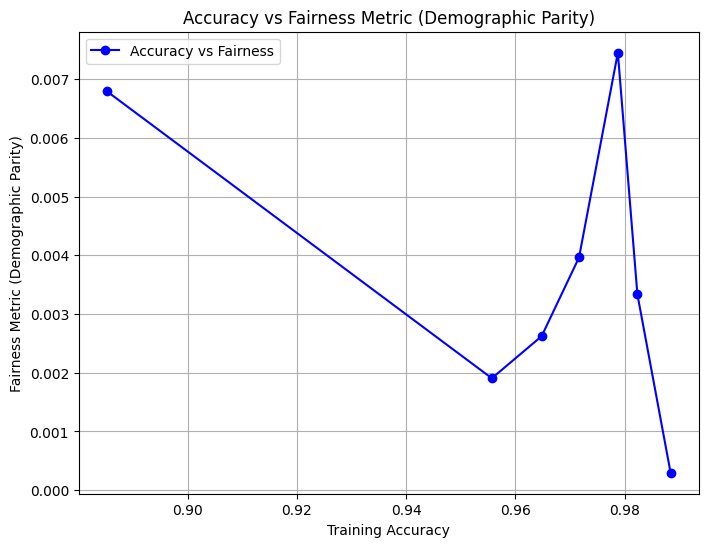

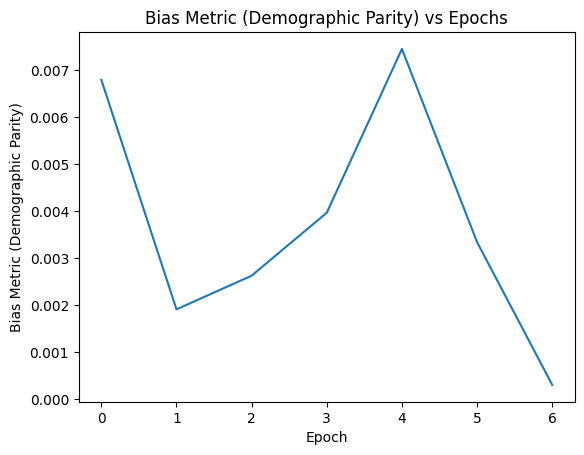

In [7]:
# Plot Accuracy vs Fairness Metric
plt.figure(figsize=(8, 6))
plt.plot(train_accuracies, fairness_metrics, marker='o', linestyle='-', color='b', label='Accuracy vs Fairness')
plt.title("Accuracy vs Fairness Metric (Demographic Parity)")
plt.xlabel("Training Accuracy")
plt.ylabel("Fairness Metric (Demographic Parity)")
plt.grid(True)
plt.legend()
plt.show()

# After training, plot bias metric
plt.plot(bias_metrics)
plt.title("Bias Metric (Demographic Parity) vs Epochs")
plt.xlabel("Epoch")
plt.ylabel("Bias Metric (Demographic Parity)")
plt.show()

In [8]:
# Calculate demographic parity gap on test data
def evaluate_fairness(test_loader, model):
    model.eval()
    predictions, genders = [], []
    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            genders += batch['gender'].tolist()

            outputs = model(input_ids)['logits'].squeeze()
            predictions += torch.sigmoid(outputs).tolist()

    # Convert to tensors
    predictions = torch.tensor(predictions)
    genders = torch.tensor(genders)

    return demographic_parity_loss(predictions, None, genders).item()

fairness_gap = evaluate_fairness(test_loader, model)
print(f"Demographic Parity Gap: {fairness_gap:.4f}")


We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


Demographic Parity Gap: 0.0001


In [ ]:
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score

val_losses,val_accuracies=[],[]
def validate_model(model, data_loader, device, criterion):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits

            # Compute loss
            loss = criterion(logits, labels)
            total_loss += loss.item()

            # Get predictions
            preds = torch.argmax(logits, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
		
    avg_loss = total_loss / len(data_loader)
    return avg_loss, all_preds, all_labels

val_loss, val_preds, val_labels = validate_model(model, test_loader, device, criterion)
val_losses.append(val_loss)
val_accuracies.append(precision_score(val_labels, val_preds, average="weighted"))


# Metrics
f1 = f1_score(val_labels, val_preds, average='weighted')
precision = precision_score(val_labels, val_preds, average='weighted')
recall = recall_score(val_labels, val_preds, average='weighted')

print(f"Validation Loss: {val_loss:.4f}")
print(f"F1 Score: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")

# Detailed classification report
print("\nClassification Report:\n")
print(classification_report(val_labels, val_preds, target_names=['Female', 'Male']))


Validation Loss: 0.4179
F1 Score: 0.9603, Precision: 0.9605, Recall: 0.9603

Classification Report:

              precision    recall  f1-score   support

      Female       0.95      0.97      0.96      2802
        Male       0.97      0.95      0.96      2794

    accuracy                           0.96      5596
   macro avg       0.96      0.96      0.96      5596
weighted avg       0.96      0.96      0.96      5596



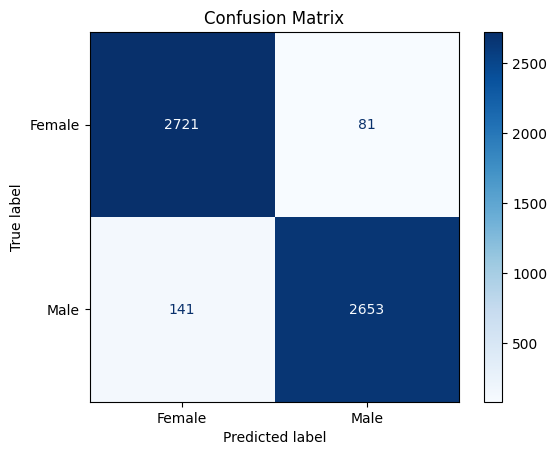

: 

In [13]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# def plot_all_metrics(epochs, train_losses, val_losses, train_accuracies, val_accuracies, learning_rates):
#     plt.figure(figsize=(18, 10))

#     # Loss plot
#     plt.subplot(2, 2, 1)
#     plt.plot(epochs, train_losses, 'b-o', label='Training Loss')
#     plt.plot(epochs, val_loss, 'r-o', label='Validation Loss')
#     plt.xlabel('Epochs')
#     plt.ylabel('Loss')
#     plt.title('Loss over Epochs')
#     plt.legend()

#     # Accuracy plot
#     plt.subplot(2, 2, 2)
#     plt.plot(epochs, train_accuracies, 'b-o', label='Training Accuracy')
#     plt.plot(epochs, val_accuracies, 'r-o', label='Validation Accuracy')
#     plt.xlabel('Epochs')
#     plt.ylabel('Accuracy')
#     plt.title('Accuracy over Epochs')
#     plt.legend()

#     # Learning rate plot
#     plt.subplot(2, 2, 3)
#     plt.plot(range(len(learning_rates)), learning_rates, 'g-o', label='Learning Rate')
#     plt.xlabel('Batch')
#     plt.ylabel('Learning Rate')
#     plt.title('Learning Rate Schedule')
#     plt.legend()

#     plt.tight_layout()
#     plt.show()

# # Call this function after training
# epochs = range(1, num_epochs + 1)
# plot_all_metrics(epochs, train_losses, val_losses, train_accuracies, val_accuracies, learning_rates)

def plot_confusion_matrix(true_labels, predictions, class_names):
    cm = confusion_matrix(true_labels, predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()


plot_confusion_matrix(val_labels, val_preds, class_names=['Female', 'Male'])
